# Import libraries

In [1]:
import snowflake.connector
import pandas as pd
import warnings
from statistics import mean
import statsmodels.api as sm
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import seaborn as sns
pd.options.display.max_columns = None
from sqlalchemy import create_engine
from snowflake.sqlalchemy import URL
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import sklearn.metrics as metrics
from sklearn.preprocessing import LabelEncoder
import scikitplot as skplt
import imblearn
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
import collections

# Definition of functions

In [2]:
def correlation_matrix(df, reference_var):
    corrmat = df.corr()
    k = 5  # number of variables for heatmap
    cols = corrmat.nlargest(k, reference_var)[reference_var].index
    cm = np.corrcoef(df[cols].values.T)
    f, ax = plt.subplots(figsize=(10, 5))
    sns.heatmap(cm, ax=ax, annot=True, cmap="Reds", linewidths=0.1, yticklabels=cols.values, xticklabels=cols.values)
    ax.set_title(reference_var + ' Correlation Matrix')
    plt.show()
    
def max_with_Nones(l):
    if all(x is None for x in l):
        return 'NaN'
    else:
        return max([i for i in l if i is not None])
    
def avg_with_Nones(l):
    if all(x is None for x in l):
        return 'NaN'
    else:
        return mean([float(i) for i in l if i is not None])

def most_common(l):
    if all(x is None for x in l):
        return 'NaN'
    else:
        return max(set(l), key=l.count)
    
def scale_data(X_train, y_train):
    in_scaler = RobustScaler()
    out_scaler = RobustScaler()
    X_train_scaled = in_scaler.fit_transform(X_train)
    y_train_scaled = out_scaler.fit_transform(y_train)
    return in_scaler, out_scaler, X_train_scaled, y_train_scaled

def del_entity_id(arraylist):
    tmp = []
    for sublist in arraylist:
        tmp.append(np.delete(sublist, 0))
    return np.array(tmp)

def backward_elim(important_df, reference_var):
    X = important_df.drop(reference_var, 1)  # Feature Matrix
    y = important_df[reference_var]  # Target Variable

    # Backward Elimination
    cols = list(X.columns)
    pmax = 1
    while (len(cols) > 0):
        p = []
        X_1 = X[cols]
        # Adding constant column of ones, mandatory for sm.OLS model
        X_1 = sm.add_constant(X_1, has_constant='add')
        model = sm.OLS(y, X_1.astype(float)).fit()
        p = pd.Series(model.pvalues.values[1:], index=cols)
        pmax = max(p)
        feature_with_p_max = p.idxmax()
        if(pmax > 0.05):
            cols.remove(feature_with_p_max)
        else:
            break
    selected_features_BE = cols
    return selected_features_BE

# Connect to Snowflake database and retrieve the data

In [3]:
ctx = snowflake.connector.connect(
    user='USER_ITW_ML_ENG',
    password='hue-hnv4fzw5azh.UQN',
    account='DB93014.eu-west-1',
    )
ctx.cursor().execute('USE warehouse WH_INTERVIEW')
ctx.cursor().execute('USE SPX_INTERVIEW.ML_ENG')


query = '''
SELECT * FROM SPX_INTERVIEW.ML_ENG.CHURN_INPUT;
'''

cur = ctx.cursor().execute(query)
df = pd.DataFrame.from_records(iter(cur), columns=[x[0] for x in cur.description])
df = df.fillna(value=np.nan)
df

,ENTITY_ID,MONTH,ORGANISATION_ID,COUNTRY,FIRST_LOAD_DATE,LAST_LOAD_DATE,CHURNING_DATE,CHURN_DATE,IS_FLAGSHIP,ORGANISATION_NAME,MAIN_ENTITY,PLAN,BUNDLE,INDUSTRY,CS_OWNER,HEALTHSCORE,NPS,NAME,FTE_AGG,AGG_INDUSTRY,HIGH_LOW_TOUCH,LAST_FUNDRAISING_AMOUNT,AGE,SEGMENT,SUB_SEGMENT,NON_REQUESTER_LOGIN_PER_USER,REQUESTER_LOGIN_PER_USER,LOGIN_PER_USER,AVERAGE_TIME_PER_USER_NON_REQUESTER,AVERAGE_TIME_PER_USER_REQUESTER,AVERAGE_TIME_PER_USER,ACTIVE_USERS_PER_USERS,AMOUNT_PAY_PER_ACTIVE_USERS,COUNT_PAY_PER_ACTIVE_USERS,NUMBER_EXPORT,PAY_PER_LOAD,ACTIVE_USERS_PER_FTE,USERS_PER_FTE,VAR_MRR_PER_FTE,VAR_MRR,FIX_MRR,NB_ACTIVE_PLASTIC_CARDS,AMOUNT_PLASTIC_CARD_PAYMENTS_EUR,NB_SINGLE_PURCHASE_PAYMENTS,AMOUNT_SINGLE_PURCHASE_PAYMENTS_EUR,NB_SUBSCRIPTIONS_PAYMENTS,AMOUNT_SUBSCRIPTIONS_PAYMENTS_EUR,NB_SMI_REQ,AMOUNT_SMI_REQ_EUR,NB_EXP_CL_REQ,AMOUNT_EXP_CL_REQ_EUR,ACCOUNTING_EXPORTS_GENERATED,NB_PLASTIC_CARD_PAYMENTS,NUMBER_OF_TEAMS_ACTIVE,AVG_SCORE,SUM_TICKETS,SUM_TICKETS_JIRA
0,ByK6WfclYg,2020-11-01,H1hZf9eFg,FR,2017-02-15,2022-02-10 18:50:35,NaT,NaT,False,a6e0076d71004b5711f3363f5254058ddc00b3a6,True,Standard,Suite,Computer Software,Aude Gobert,65,75.0,a6e0076d71004b5711f3363f5254058ddc00b3a6,143,Tech,High,2.7825487E7,45,1. Emma,2. Lions,29.000000,6.357143,13.150000,4.473669166667,0.472751321429,0.652055000000,0.547619,21862.161739130435,5.826087,0.0,10.056594400000,0.160839000000,0.293706000000,2.23223776,638.42,399.00,19,0E-8,28.0,10966.58000000,34.0,18086.79000000,32.0,272864.48,5.0,530.88,0.0,0.0,3.0,NaN,3.0,NaN
1,ByQ0AUP-l,2016-11-01,HJGgM8DtfPg,NL,2016-11-16,2022-01-28 18:50:39,NaT,NaT,False,6652c1ad036360d05ca4ed74b9b48f7babd771e1,True,Lite,Online + Expenses,International Trade and Development,Anne-Sophie Lajouanie,65,83.0,6652c1ad036360d05ca4ed74b9b48f7babd771e1,145,Others,Low,NaN,0,1. Emma,2. Lions,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN
2,ByNXG9mVbf,2019-08-01,HJ113ksxz,FR,2017-12-22,2019-09-12 13:43:32,2020-04-15 10:29:47,2020-04-17 10:34:11,NaN,7f7e6f6b342b55bc01109af44ff2b92301b57401,NaN,NaN,NaN,NaN,Thibault Lemaitre,25,-100.0,80b98435120cb9f458d6944022754fbb79484291,5,Others,Low,NaN,20,4. NA,NaN,NaN,NaN,NaN,NaN,NaN,2.170000000000,0.500000,913.870000000000,12.000000,NaN,1.827740000000,0.200000000000,0.400000000000,0.72600000,7.26,19.00,1,913.87000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,NaN,NaN,NaN,NaN
3,ByLCj0cP2l,2018-05-01,ryps05P3l,FR,2017-04-06,2018-02-22 15:59:38,2020-05-18 13:56:41,2020-08-19 09:54:28,NaN,00ec302277582f3bc7eaed47d07b0e040cbf18ce,NaN,NaN,NaN,Marketing and Advertising,Thibault Lemaitre,25,-50.0,00ec302277582f3bc7eaed47d07b0e040cbf18ce,4,Retail,Low,NaN,13,3. Others,NaN,NaN,NaN,NaN,NaN,NaN,3.388889000000,0.333333,150.420000000000,9.000000,NaN,NaN,0.250000000000,0.750000000000,0.56250000,2.25,0.00,1,0E-8,0.0,0E-8,9.0,150.42000000,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
4,ByK6WfclYg,2021-06-01,H1hZf9eFg,FR,2017-02-15,2022-02-10 18:50:35,NaT,NaT,False,a6e0076d71004b5711f3363f5254058ddc00b3a6,True,Standard,Suite,Computer Software,Aude Gobert,65,75.0,a6e0076d71004b5711f3363f5254058ddc00b3a6,143,Tech,High,2.7825487E7,52,1. Emma,2. Lions,31.800000,5.588235,11.545455,14.503815800000,0.318486354839,1.406032611111,0.410714,22393.006521739130,7.217391,0.0,NaN,0.160839000000,0.391608000000,1.86475524,533.32,399.00,16,1918.45000000,6.0,4871.80000000,46.0,19843.43000000,59.0,364657.83,41.0,10168.25,0.0,44.0,3.0,NaN,3.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105207,ww80Jphits,2020-09-01,63jDfGJd5,FR,2020-05-22,2022-02-02 09:06:41,NaT,NaT,False,a5e9937f6bf33de98e5759835c047f6a4965f94f,True,Essentials,Suite,Research,Yanis Bacetti,65,14.0,a5e9937f6bf33de98e5759835c047f6a4965f94f,38,Others,Low,NaN,4,1. Emma,1. Nemo,14.000000,4.300000,6.538462,4.38520533

# Change data type

In [4]:
df["AGE"] = pd.to_numeric(df["AGE"])
df["AVERAGE_TIME_PER_USER_REQUESTER"] = pd.to_numeric(df["AVERAGE_TIME_PER_USER_REQUESTER"])
df["AVERAGE_TIME_PER_USER_NON_REQUESTER"] = pd.to_numeric(df["AVERAGE_TIME_PER_USER_NON_REQUESTER"])
df["COUNT_PAY_PER_ACTIVE_USERS"] = pd.to_numeric(df["COUNT_PAY_PER_ACTIVE_USERS"])
df["AMOUNT_SUBSCRIPTIONS_PAYMENTS_EUR"] = pd.to_numeric(df["AMOUNT_SUBSCRIPTIONS_PAYMENTS_EUR"])
df["AMOUNT_SINGLE_PURCHASE_PAYMENTS_EUR"] = pd.to_numeric(df["AMOUNT_SINGLE_PURCHASE_PAYMENTS_EUR"])
df["AVERAGE_TIME_PER_USER"] = pd.to_numeric(df["AVERAGE_TIME_PER_USER"])
df["AMOUNT_PLASTIC_CARD_PAYMENTS_EUR"] = pd.to_numeric(df["AMOUNT_PLASTIC_CARD_PAYMENTS_EUR"])
df["NON_REQUESTER_LOGIN_PER_USER"] = pd.to_numeric(df["NON_REQUESTER_LOGIN_PER_USER"])
df["ACTIVE_USERS_PER_USERS"] = pd.to_numeric(df["ACTIVE_USERS_PER_USERS"])
df["ACTIVE_USERS_PER_FTE"] = pd.to_numeric(df["ACTIVE_USERS_PER_FTE"])
df["PAY_PER_LOAD"] = pd.to_numeric(df["PAY_PER_LOAD"])
df["VAR_MRR"] = pd.to_numeric(df["VAR_MRR"])
df["REQUESTER_LOGIN_PER_USER"] = pd.to_numeric(df["REQUESTER_LOGIN_PER_USER"])
df["LOGIN_PER_USER"] = pd.to_numeric(df["LOGIN_PER_USER"])
df["AMOUNT_PAY_PER_ACTIVE_USERS"] = pd.to_numeric(df["AMOUNT_PAY_PER_ACTIVE_USERS"])
df["USERS_PER_FTE"] = pd.to_numeric(df["USERS_PER_FTE"])
df["VAR_MRR_PER_FTE"] = pd.to_numeric(df["VAR_MRR_PER_FTE"])
df["HEALTHSCORE"] = pd.to_numeric(df["HEALTHSCORE"])
df["LAST_FUNDRAISING_AMOUNT"] = pd.to_numeric(df["LAST_FUNDRAISING_AMOUNT"])
df["FIX_MRR"] = pd.to_numeric(df["FIX_MRR"])
df["NB_ACTIVE_PLASTIC_CARDS"] = pd.to_numeric(df["NB_ACTIVE_PLASTIC_CARDS"])

In [5]:
df.dtypes

ENTITY_ID                                      object
MONTH                                          object
ORGANISATION_ID                                object
COUNTRY                                        object
FIRST_LOAD_DATE                                object
LAST_LOAD_DATE                         datetime64[ns]
CHURNING_DATE                          datetime64[ns]
CHURN_DATE                             datetime64[ns]
IS_FLAGSHIP                                    object
ORGANISATION_NAME                              object
MAIN_ENTITY                                    object
PLAN                                           object
BUNDLE                                         object
INDUSTRY                                       object
CS_OWNER                                       object
HEALTHSCORE                                   float64
NPS                                           float64
NAME                                           object
FTE_AGG                     

# Explore nans

In [6]:
df.isna().sum().sort_values()

ENTITY_ID                                  0
NB_ACTIVE_PLASTIC_CARDS                    0
SEGMENT                                    0
AGE                                        0
NAME                                       0
ORGANISATION_NAME                          0
FTE_AGG                                    0
ORGANISATION_ID                            0
FIRST_LOAD_DATE                            0
MONTH                                      0
COUNTRY                                    0
CS_OWNER                                2158
AGG_INDUSTRY                            2158
LAST_LOAD_DATE                          3064
HEALTHSCORE                             5301
FIX_MRR                                 5399
VAR_MRR_PER_FTE                         5399
VAR_MRR                                 5399
USERS_PER_FTE                           5422
HIGH_LOW_TOUCH                          6504
BUNDLE                                  9524
AVERAGE_TIME_PER_USER                  10965
INDUSTRY  

# Describe dataset

In [7]:
df.describe()

,HEALTHSCORE,NPS,FTE_AGG,LAST_FUNDRAISING_AMOUNT,AGE,NON_REQUESTER_LOGIN_PER_USER,REQUESTER_LOGIN_PER_USER,LOGIN_PER_USER,AVERAGE_TIME_PER_USER_NON_REQUESTER,AVERAGE_TIME_PER_USER_REQUESTER,AVERAGE_TIME_PER_USER,ACTIVE_USERS_PER_USERS,AMOUNT_PAY_PER_ACTIVE_USERS,COUNT_PAY_PER_ACTIVE_USERS,NUMBER_EXPORT,PAY_PER_LOAD,ACTIVE_USERS_PER_FTE,USERS_PER_FTE,VAR_MRR_PER_FTE,VAR_MRR,FIX_MRR,NB_ACTIVE_PLASTIC_CARDS,AMOUNT_PLASTIC_CARD_PAYMENTS_EUR,NB_SINGLE_PURCHASE_PAYMENTS,AMOUNT_SINGLE_PURCHASE_PAYMENTS_EUR,NB_SUBSCRIPTIONS_PAYMENTS,AMOUNT_SUBSCRIPTIONS_PAYMENTS_EUR,NB_SMI_REQ,AMOUNT_SMI_REQ_EUR,NB_EXP_CL_REQ,AMOUNT_EXP_CL_REQ_EUR,ACCOUNTING_EXPORTS_GENERATED,NB_PLASTIC_CARD_PAYMENTS,NUMBER_OF_TEAMS_ACTIVE,AVG_SCORE,SUM_TICKETS,SUM_TICKETS_JIRA
count,99911.000000,82956.000000,105212.000000,3.531100e+04,105212.000000,63534.000000,52424.000000,64075.000000,66463.000000,58252.000000,94247.000000,88065.000000,9.008200e+04,90082.000000,48197.000000,5.496300e+04,90082.000000,99790.000000,99813.000000,99813.000000,99813.000000,105212.000000,70493.000000,86817.000000,86817.000000,72932.000000,72932.000000,19264.000000,1.926400e+04,39854.000000,39854.000000,48197.000000,70493.000000,70148.000000,22606.000000,51248.000000,12080.000000
mean,59.405171,42.568349,156.805497,2.031194e+08,14.860425,18.153521,6.354628,11.091192,15.149318,4.239354,4.702563,0.749874,6.326518e+03,10.611686,2.171255,3.044281e+02,0.241760,0.412848,2.788319,186.060667,177.682897,4.560554,3122.212543,13.718293,3444.561325,27.420172,5949.261016,38.802897,2.175009e+05,20.254855,1666.541742,2.171255,39.973813,8.334849,8.385501,3.277708,1.786093
std,15.880821,50.538046,2649.034263,7.006218e+09,13.545387,15.650833,13.377223,12.907941,225.871524,14.736231,41.567368,0.836370,2.796586e+05,51.883591,8.757125,6.282826e+04,0.338754,0.332810,42.574459,389.628856,225.214832,10.049025,6803.157391,36.653175,8646.477393,127.777821,14660.367678,99.900023,1.590367e+06,78.040199,9190.901450,8.757125,86.960964,13.340301,2.146052,7.597939,1.491463
min,25.000000,-100.000000,1.000000,0.000000e+00,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.002809,-8.598356e+04,1.000000,0.000000,-2.393755e+00,0.000028,0.000008,-109.881250,-901.300000,-1538.770000,0.000000,-12778.610000,0.000000,-143743.790000,0.000000,-21173.470000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,65.000000,13.000000,13.000000,3.535257e+06,4.000000,8.000000,3.000000,5.533333,2.987541,0.714499,1.042730,0.352941,3.944262e+02,3.666667,0.000000,4.778463e-01,0.070707,0.116667,0.187063,11.980000,50.000000,0.000000,150.670000,1.000000,8.400000,2.000000,122.757500,0.000000,0.000000e+00,0.000000,0.000000,0.000000,3.000000,2.000000,8.000000,1.000000,1.000000
50%,65.000000,50.000000,33.000000,1.327174e+07,11.000000,14.200000,4.750000,8.666667,6.169328,1.665280,2.000000,0.583333,8.921171e+02,6.500000,0.000000,8.015286e-01,0.171429,0.333333,0.970675,61.090000,119.000000,2.000000,974.259000,4.000000,723.500000,10.000000,1207.208850,11.000000,2.375856e+04,3.000000,153.000000,0.000000,15.000000,5.000000,9.000000,2.000000,1.000000
75%,65.000000,82.000000,88.000000,5.111432e+07,22.000000,23.500000,7.666667,13.500000,11.778506,4.000000,3.960086,0.888889,2.105636e+03,11.000000,2.000000,1.267912e+00,0.333333,0.669159,2.666053,198.450000,291.330000,5.000000,3333.750000,14.000000,3389.160000,29.000000,5675.937500,45.000000,1.364851e+05,16.000000,1030.810000,2.000000,43.000000,10.000000,10.000000,4.000000,2.000000
max,90.000000,100.000000,251784.000000,3.400000e+11,73.000000,317.000000,2735.125000,2193.433333,31578.907845,1718.653083,7433.296659,42.000000,5.237544e+07,5513.500000,860.000000,1.469543e+07,20.000000,8.000000,9351.860000,18703.720000,4729.000000,297.000000,252643.070000,1698.000000,403295.540000,11027.000000,540822.970000,4607.000000,1.421413e+08,3576.000000,892903.510000,860.000000,2590.000000,399.000000,10.000000,277.000000,20.000000


# Exploratory Analysis
- Identify plans distribution

<AxesSubplot:ylabel='# of plans'>

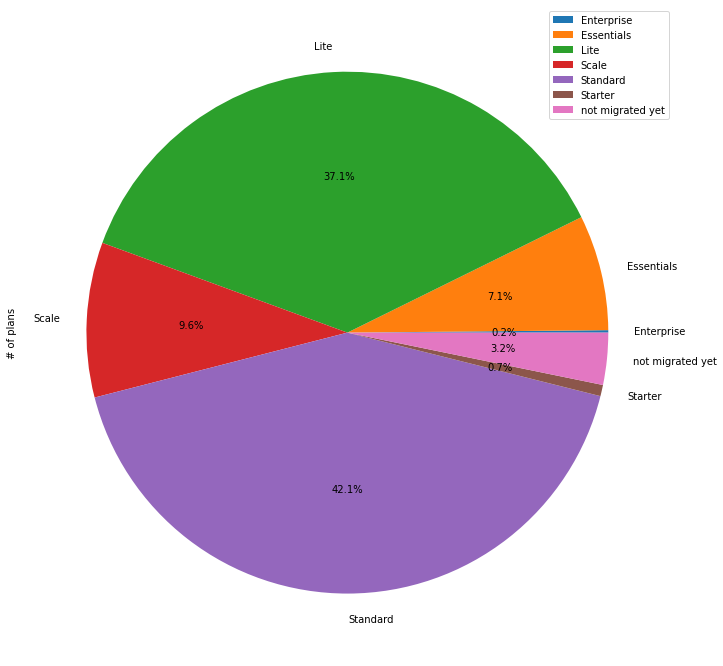

In [8]:
plans_df = df.groupby(['PLAN']).size().reset_index(name='# of plans')
plans_df.set_index('PLAN', inplace=True)
plans_df.plot(y='# of plans', kind='pie', autopct="%1.1f%%",figsize=(28, 12))

- France is the country with most customers

<AxesSubplot:ylabel='# of countries'>

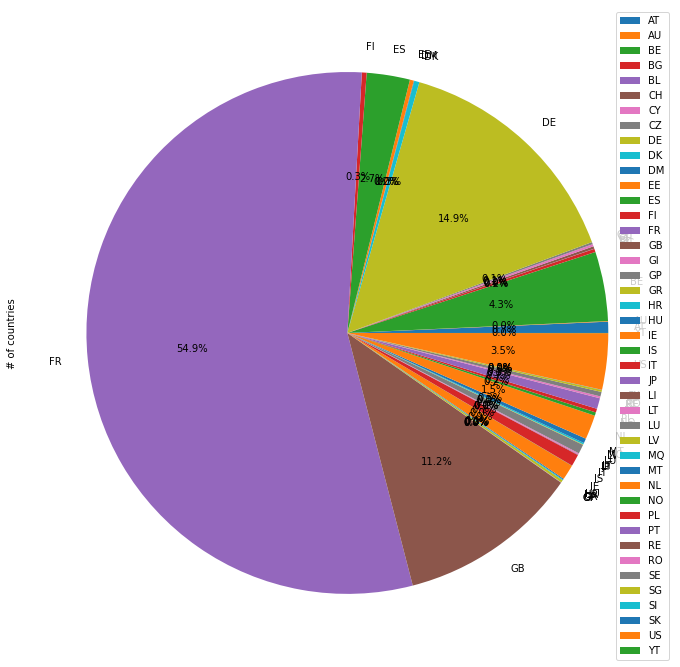

In [9]:
countries_df = df.groupby(['COUNTRY']).size().reset_index(name='# of countries')
countries_df.set_index('COUNTRY', inplace=True)
countries_df.plot(y='# of countries', kind='pie', autopct="%1.1f%%",figsize=(28, 12))

- 2021 is the year with the most customers

<AxesSubplot:xlabel='year'>

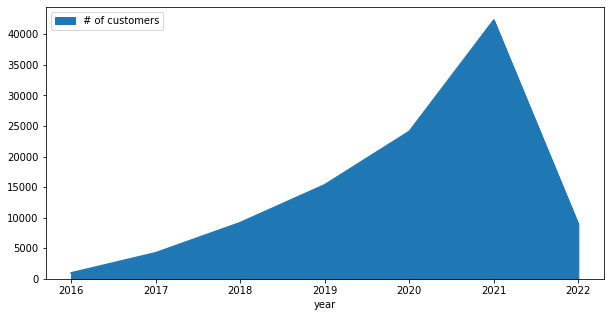

In [10]:
m_df = df[['MONTH','ENTITY_ID']].copy()
m_df['MONTH'] = pd.to_datetime(m_df['MONTH'])
m_df['year'] = m_df['MONTH'].dt.year
m_df.groupby(['year']).size().reset_index(name='# of customers').set_index('year').plot(figsize=(10,5),kind='area')

- 2021 was the most churning year

<AxesSubplot:xlabel='CHURN_DATEs'>

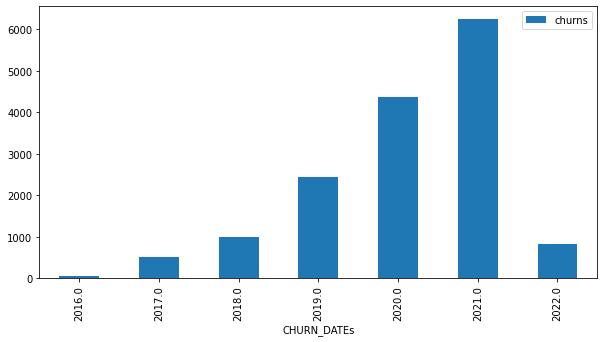

In [11]:
cdate_df = df[['CHURN_DATE']].copy()
cdate_df['CHURN_DATE'] = pd.to_datetime(cdate_df['CHURN_DATE'])
cdate_df['CHURN_DATEs'] = cdate_df['CHURN_DATE'].dt.year
cdate_df.groupby(['CHURN_DATEs']).size().reset_index(name='churns').set_index('CHURN_DATEs').plot(figsize=(10,5),kind='bar')

# Identify outliers or negative values

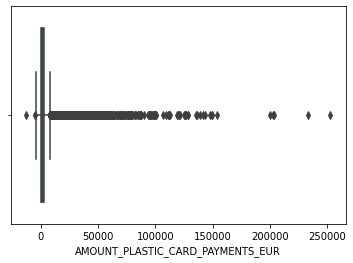

In [12]:
sns.boxplot(x=df['AMOUNT_PLASTIC_CARD_PAYMENTS_EUR'])
df['AMOUNT_PLASTIC_CARD_PAYMENTS_EUR'] = df['AMOUNT_PLASTIC_CARD_PAYMENTS_EUR'].abs()
df['AMOUNT_PAY_PER_ACTIVE_USERS'] = df['AMOUNT_PAY_PER_ACTIVE_USERS'].abs()
df['PAY_PER_LOAD'] = df['PAY_PER_LOAD'].abs()
df['AMOUNT_SINGLE_PURCHASE_PAYMENTS_EUR'] = df['AMOUNT_SINGLE_PURCHASE_PAYMENTS_EUR'].abs()
df['AMOUNT_SUBSCRIPTIONS_PAYMENTS_EUR'] = df['AMOUNT_SUBSCRIPTIONS_PAYMENTS_EUR'].abs()

# Let's create our features

# Convert categorical to numerical

In [13]:
df["COUNTRY"] = df["COUNTRY"].astype('category').cat.codes.replace(-1,np.nan)
df["PLAN"] = df["PLAN"].astype('category').cat.codes.replace(-1,np.nan)
df["BUNDLE"] = df["BUNDLE"].astype('category').cat.codes.replace(-1,np.nan)
df["INDUSTRY"] = df["INDUSTRY"].astype('category').cat.codes.replace(-1,np.nan)
df["CS_OWNER"] = df["CS_OWNER"].astype('category').cat.codes.replace(-1,np.nan)
df["AGG_INDUSTRY"] = df["AGG_INDUSTRY"].astype('category').cat.codes.replace(-1,np.nan)
df["HIGH_LOW_TOUCH"] = df["HIGH_LOW_TOUCH"].astype('category').cat.codes.replace(-1,np.nan)

df[['COUNTRY','PLAN','BUNDLE','INDUSTRY','CS_OWNER','AGG_INDUSTRY','HIGH_LOW_TOUCH']]

,COUNTRY,PLAN,BUNDLE,INDUSTRY,CS_OWNER,AGG_INDUSTRY,HIGH_LOW_TOUCH
0,14,4.0,3.0,25.0,12.0,3.0,0.0
1,31,2.0,1.0,67.0,7.0,1.0,1.0
2,14,NaN,NaN,NaN,63.0,1.0,1.0
3,14,NaN,NaN,86.0,63.0,2.0,1.0
4,14,4.0,3.0,25.0,12.0,3.0,0.0
...,...,...,...,...,...,...,...
105207,14,1.0,3.0,129.0,67.0,1.0,1.0
105208,15,4.0,1.0,147.0,17.0,1.0,0.0
105209,15,NaN,3.0,128.0,17.0,1.0,0.0
105210,14,2.0,3.0,25.0,67.0,3.0,1.0


# Create new column based on difference in days between churning_date and churn_date dates

In [14]:
df[['FIRST_LOAD_DATE','LAST_LOAD_DATE']] = df[['FIRST_LOAD_DATE','LAST_LOAD_DATE']].apply(pd.to_datetime)
df[['CHURNING_DATE','CHURN_DATE']] = df[['CHURNING_DATE','CHURN_DATE']].apply(pd.to_datetime)

df['fload_lload'] = (df['LAST_LOAD_DATE'] - df['FIRST_LOAD_DATE']).dt.days
df['churning_churn'] = (df['CHURN_DATE'] - df['CHURNING_DATE']).dt.days

# Create new column based on churn_date
- If churn_date in not null we assign 1, otherwise 0.
- This way we formulate our problem as classification, trying to assess the risk of company based on its base, by giving a risk possibility

In [15]:
df['churn'] = np.where(np.isnan(df['CHURN_DATE'].values), 0, 1)

# Sort month column
- this way we take time into consideration

In [16]:
df.sort_values(by=['MONTH'], inplace=True, ascending=True)

# Convert column of boolean values to a column of integers 1 or 0

In [17]:
df.IS_FLAGSHIP = df.IS_FLAGSHIP.replace({True: 1, False: 0})

# Groupby entity_id (customers)

In [18]:
all_cols = list(df.columns.values)
cols_to_be_grouped = ['ENTITY_ID']
entityid_df = df.groupby(cols_to_be_grouped, as_index=False)[list(set(all_cols) - set(cols_to_be_grouped))].agg(lambda x: list(x))
entityid_df

,ENTITY_ID,NPS,VAR_MRR,AMOUNT_EXP_CL_REQ_EUR,NB_PLASTIC_CARD_PAYMENTS,CHURNING_DATE,AVG_SCORE,ACCOUNTING_EXPORTS_GENERATED,AMOUNT_SUBSCRIPTIONS_PAYMENTS_EUR,COUNTRY,churning_churn,NB_ACTIVE_PLASTIC_CARDS,REQUESTER_LOGIN_PER_USER,fload_lload,IS_FLAGSHIP,AVERAGE_TIME_PER_USER_REQUESTER,AMOUNT_PAY_PER_ACTIVE_USERS,AMOUNT_SMI_REQ_EUR,churn,INDUSTRY,AMOUNT_SINGLE_PURCHASE_PAYMENTS_EUR,AVERAGE_TIME_PER_USER_NON_REQUESTER,SUM_TICKETS,BUNDLE,ORGANISATION_ID,AGG_INDUSTRY,AMOUNT_PLASTIC_CARD_PAYMENTS_EUR,NUMBER_OF_TEAMS_ACTIVE,ACTIVE_USERS_PER_FTE,NON_REQUESTER_LOGIN_PER_USER,FIRST_LOAD_DATE,NUMBER_EXPORT,VAR_MRR_PER_FTE,HEALTHSCORE,HIGH_LOW_TOUCH,CHURN_DATE,ACTIVE_USERS_PER_USERS,NAME,USERS_PER_FTE,PLAN,NB_SMI_REQ,LAST_LOAD_DATE,SUM_TICKETS_JIRA,CS_OWNER,NB_SUBSCRIPTIONS_PAYMENTS,MAIN_ENTITY,PAY_PER_LOAD,NB_EXP_CL_REQ,FIX_MRR,FTE_AGG,COUNT_PAY_PER_ACTIVE_USERS,NB_SINGLE_PURCHASE_PAYMENTS,LAST_FUNDRAISING_AMOUNT,AGE,SEGMENT,MONTH,AVERAGE_TIME_PER_USER,ORGANISATION_NAME,SUB_SEGMENT,LOGIN_PER_USER
0,--p-12dr9z7wv-,"[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100...","[0.0, 51.86, 4.38, 141.1, 23.14, 5.28, 6.12, 4...","[nan, nan, nan, nan, nan, nan, nan, nan, nan]","[nan, 3.0, 1.0, 57.0, 43.0, 7.0, 3.0, 2.0, 1.0]","[NaT, NaT, NaT, NaT, NaT, NaT, NaT, NaT, NaT]","[nan, nan, 10.0, 10.0, nan, 9.0, nan, nan, 7.0]","[nan, nan, nan, nan, nan, nan, nan, nan, nan]","[nan, 353.85, 353.85, 353.85, 96.0, 21.0, 21.0...","[8, 8, 8, 8, 8, 8, 8, 8, 8]","[nan, nan, nan, nan, nan, nan, nan, nan, nan]","[0, 3, 3, 3, 3, 3, 3, 3, 3]","[nan, 3.75, 2.6, 9.0, 8.2, 3.428571, 3.75, 3.4...","[104.0, 104.0, 104.0, 104.0, 104.0, 104.0, 104...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[1.466666666667, 2.3407408, 0.2226416, 3.49223...","[nan, 1743.97, 1380.07, 1886.395, 354.882, 154...","[nan, 4973.01, 5156.08, 0.0, 0.0, 7273.7, 8245...","[0, 0, 0, 0, 0, 0, 0, 0, 0]","[nan, nan, nan, nan, nan, nan, nan, nan, nan]","[nan, 1529.09, 0.0, 2686.31, 601.68, 22.98, 0....","[15.5861485, 3.33333325, 7.816, 15.304813, 6.2...","[nan, 1.0, 1.0, nan, 1.0, 2.0, 3.0, 3.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[b65yhec9qdgnxd, b65yhec9qdgnxd, b65yhec9qdgnx...","[nan, nan, nan, nan, nan, nan, nan, nan, nan]","[nan, 119.93, 10.35, 8278.21, 1076.73, 399.72,...","[2.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0]","[nan, 0.266667, 0.266667, 0.4, 0.333333, 0.333...","[nan, 38.0, 18.5, 58.0, 25.5, 37.5, 39.5, 22.6...","[2021-06-16 00:00:00, 2021-06-16 00:00:00, 202...","[nan, nan, nan, nan, nan, nan, nan, nan, nan]","[0.0, 3.45733333, 0.292, 9.40666667, 1.5426666...","[nan, nan, nan, nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan, nan, nan, nan]","[NaT, NaT, NaT, NaT, NaT, NaT, NaT, NaT, NaT]","[nan, 0.363636, 0.333333, 0.5, 0.384615, 0.333...","[bb021a8b09b1acd854c5794dd7b0475ccef62c6a, bb0...","[nan, 0.733333, 0.8, 0.8, 0.866667, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]","[nan, 1.0, 2.0, 0.0, 0.0, 4.0, 4.0, 5.0, 3.0]","[2021-09-28 18:51:33, 2021-09-28 18:51:33, 202...","[nan, nan, nan, nan, nan, 1.0, nan, nan, nan]","[nan, nan, nan, nan, nan, nan, nan, nan, nan]","[nan, 3.0, 3.0, 3.0, 2.0, 1.0, 1.0, 2.0, 1.0]","[nan, nan, nan, nan, nan, nan, nan, nan, nan]","[nan, nan, nan, 0.754558, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan]","[50.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[15, 15, 15, 15, 15, 15, 15, 15, 15]","[nan, 2.5, 1.5, 10.666667, 10.0, 2.8, 2.0, 1.8...","[nan, 3.0, 0.0, 4.0, 5.0, 2.0, 0.0, 1.0, 1.0]","[nan, nan, nan, nan, nan, nan, nan, nan, nan]","[0, 1, 2, 3, 4, 5, 6, 7, 8]","[4. NA, 4. NA, 4. NA, 4. NA, 4. NA, 4. NA, 4. ...","[2021-06-01, 2021-07-01, 2021-08-01, 2021-09-0...","[3.527492625, 1.385620888889, 0.9700375, 2.457...","[b327d71086fa83bb2471fd9889086632f2818c8d, b32...","[nan, nan, nan, nan, nan, nan, nan, nan, nan]","[nan, 10.6, 7.142857, 18.8, 13.142857, 11.0, 1..."
1,-0iw08wtqdeoih,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[0.0, 0.0, 0.0, 6.99, 6.98, 21.75, 14.9, 15.14..

# Calculate statistics per entity (customer)

In [19]:
max_cols = ['AGE','AVERAGE_TIME_PER_USER_REQUESTER','SUM_TICKETS',
            'LAST_FUNDRAISING_AMOUNT','SUM_TICKETS_JIRA',
            'AVERAGE_TIME_PER_USER_NON_REQUESTER',
            'COUNT_PAY_PER_ACTIVE_USERS',
            'AMOUNT_SUBSCRIPTIONS_PAYMENTS_EUR',
            'ACCOUNTING_EXPORTS_GENERATED','AMOUNT_SINGLE_PURCHASE_PAYMENTS_EUR',
            'AVERAGE_TIME_PER_USER','AMOUNT_SMI_REQ_EUR',
            'NB_ACTIVE_PLASTIC_CARDS','NB_SMI_REQ',
            'AMOUNT_PLASTIC_CARD_PAYMENTS_EUR','AVG_SCORE',
            'fload_lload','churn']

avg_cols = ['NUMBER_OF_TEAMS_ACTIVE','NB_SINGLE_PURCHASE_PAYMENTS',
            'NUMBER_EXPORT','NON_REQUESTER_LOGIN_PER_USER',
            'NPS','ACTIVE_USERS_PER_USERS', 'ACTIVE_USERS_PER_FTE',
            'PAY_PER_LOAD','NB_EXP_CL_REQ','VAR_MRR',
            'REQUESTER_LOGIN_PER_USER','LOGIN_PER_USER',
            'NB_SUBSCRIPTIONS_PAYMENTS',
            'AMOUNT_PAY_PER_ACTIVE_USERS','USERS_PER_FTE','VAR_MRR_PER_FTE',
            'AMOUNT_EXP_CL_REQ_EUR','NB_PLASTIC_CARD_PAYMENTS']

most_cols = ['AGG_INDUSTRY','churning_churn','FTE_AGG',
             'BUNDLE','PLAN','IS_FLAGSHIP','CS_OWNER',
             'HIGH_LOW_TOUCH','COUNTRY','HEALTHSCORE',
             'INDUSTRY','FIX_MRR','MAIN_ENTITY','NAME',
             'ORGANISATION_ID','ORGANISATION_NAME']

stat_df = pd.DataFrame()
for max_col in max_cols:
    entityid_df[max_col] = entityid_df.apply(lambda entityid_df: max_with_Nones(entityid_df[max_col]), axis=1)

for avg_col in avg_cols:
    entityid_df[avg_col] = entityid_df.apply(lambda entityid_df: avg_with_Nones(entityid_df[avg_col]), axis=1)
    
for most_col in most_cols:
    entityid_df[most_col] = entityid_df.apply(lambda entityid_df: most_common(entityid_df[most_col]), axis=1)

# Drop unnecessary columns

In [20]:
entityid_df.drop(['MONTH','FIRST_LOAD_DATE','LAST_LOAD_DATE',
                'CHURNING_DATE','CHURN_DATE','SEGMENT','SUB_SEGMENT'], 1, inplace=True)
entityid_df

,ENTITY_ID,NPS,VAR_MRR,AMOUNT_EXP_CL_REQ_EUR,NB_PLASTIC_CARD_PAYMENTS,AVG_SCORE,ACCOUNTING_EXPORTS_GENERATED,AMOUNT_SUBSCRIPTIONS_PAYMENTS_EUR,COUNTRY,churning_churn,NB_ACTIVE_PLASTIC_CARDS,REQUESTER_LOGIN_PER_USER,fload_lload,IS_FLAGSHIP,AVERAGE_TIME_PER_USER_REQUESTER,AMOUNT_PAY_PER_ACTIVE_USERS,AMOUNT_SMI_REQ_EUR,churn,INDUSTRY,AMOUNT_SINGLE_PURCHASE_PAYMENTS_EUR,AVERAGE_TIME_PER_USER_NON_REQUESTER,SUM_TICKETS,BUNDLE,ORGANISATION_ID,AGG_INDUSTRY,AMOUNT_PLASTIC_CARD_PAYMENTS_EUR,NUMBER_OF_TEAMS_ACTIVE,ACTIVE_USERS_PER_FTE,NON_REQUESTER_LOGIN_PER_USER,NUMBER_EXPORT,VAR_MRR_PER_FTE,HEALTHSCORE,HIGH_LOW_TOUCH,ACTIVE_USERS_PER_USERS,NAME,USERS_PER_FTE,PLAN,NB_SMI_REQ,SUM_TICKETS_JIRA,CS_OWNER,NB_SUBSCRIPTIONS_PAYMENTS,MAIN_ENTITY,PAY_PER_LOAD,NB_EXP_CL_REQ,FIX_MRR,FTE_AGG,COUNT_PAY_PER_ACTIVE_USERS,NB_SINGLE_PURCHASE_PAYMENTS,LAST_FUNDRAISING_AMOUNT,AGE,AVERAGE_TIME_PER_USER,ORGANISATION_NAME,LOGIN_PER_USER
0,--p-12dr9z7wv-,100.0,26.523333,NaN,NaN,NaN,NaN,NaN,8,NaN,3,NaN,104.0,0.0,7.259279,NaN,NaN,0,NaN,NaN,29.983834,NaN,0.0,b65yhec9qdgnxd,NaN,NaN,3.777778,NaN,NaN,NaN,1.768222,NaN,NaN,NaN,bb021a8b09b1acd854c5794dd7b0475ccef62c6a,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,15,NaN,NaN,NaN,8,5.182292,b327d71086fa83bb2471fd9889086632f2818c8d,NaN
1,-0iw08wtqdeoih,NaN,7.941429,NaN,NaN,NaN,NaN,NaN,2,NaN,1,NaN,333.0,0.0,NaN,NaN,NaN,0,NaN,NaN,12.649444,5.0,1.0,tzuard-sq0soeu,1.0,NaN,NaN,NaN,8.750000,NaN,0.567245,65.0,1.0,NaN,a6b3965dd6e30688ca93cc7b1ac3a021b8447948,0.540817,2.0,NaN,NaN,12.0,NaN,NaN,NaN,NaN,50.0,7,NaN,NaN,NaN,13,4.285714,44471f66d6eb997cdcf7a9d657175c964da5a9b7,10.142857
2,-1p9n4fyn7xken,NaN,40.722000,NaN,NaN,NaN,NaN,NaN,14,NaN,3,NaN,286.0,0.0,26.861111,NaN,NaN,0,110.0,NaN,35.581967,11.0,3.0,lj74ra6fdatmrs,1.0,NaN,NaN,NaN,27.300000,NaN,2.438292,65.0,1.0,NaN,661b4b9fa495a1f098c677fbf284f0caa26e7a0a,0.550000,4.0,NaN,NaN,12.0,NaN,NaN,NaN,NaN,50.0,8,NaN,NaN,NaN,9,17.048812,0be7ee72dc90c72f708fd3180265c501505bc602,21.398333
3,-1sv6xt88a1ivw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14,7.0,0,NaN,NaN,NaN,NaN,NaN,NaN,1,124.0,NaN,13.500000,NaN,3.0,rxawaom7pcu9y4,1.0,NaN,NaN,NaN,NaN,NaN,NaN,65.0,1.0,NaN,2174e33e8db0cfbeacc9859f278463b6743cfdd6,NaN,NaN,NaN,NaN,32.0,NaN,NaN,NaN,NaN,NaN,44,NaN,NaN,NaN,2,13.500000,2174e33e8db0cfbeacc9859f278463b6743cfdd6,NaN
4,-29j_ewxfo5ss3,NaN,21.059091,NaN,NaN,NaN,NaN,NaN,14,NaN,0,NaN,213.0,0.0,263.487805,NaN,1886949.0,0,26.0,NaN,51.460504,NaN,2.0,nh52e-3psxsddu,1.0,NaN,NaN,NaN,NaN,NaN,0.542386,25.0,1.0,NaN,49cf023b1deb54eeb13a2bce6ecf91ec8cb85327,NaN,2.0,418.0,NaN,7.0,NaN,True,NaN,NaN,159.0,20,NaN,NaN,NaN,10,67.358786,49cf023b1deb54eeb13a2bce6ecf91ec8cb85327,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5872,zyvy8jmjd48806,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15,NaN,0,NaN,-1.0,NaN,NaN,NaN,NaN,0,53.0,NaN,22.522267,NaN,NaN,xhbp19bucxc3lh,1.0,NaN,NaN,NaN,NaN,NaN,NaN,25.0,1.0,NaN,7f6f49d566b6d34213c6cff0333ae5288796c4ce,NaN,NaN,NaN,NaN,4.0,NaN,True,NaN,NaN,NaN,180,NaN,NaN,32.0,0,11.215726,7f6f49d566b6d34213c6cff0333ae5288796c4ce,NaN
5873,zyyt79ue2y0q_x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14,NaN,0,NaN,NaN,NaN,0.000000,NaN,NaN,0,63.0,NaN,59.597765,NaN,3.0,crq-fr17hiuki3,3.0,NaN,NaN,NaN,NaN,NaN,NaN,65.0,0.0,NaN,6fa2de3adb942bccba2623340445ff2dca9d207d,NaN,2.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,179.0,47,NaN,NaN,500000.0,11,59.597765,6fa2de3adb942bccba2623340445ff2dca9d207d,NaN
5874,zyz9ciui8xhmy1,-33.0,223.068421,NaN,NaN,NaN,NaN,NaN,14,NaN,5,NaN,550.0,0.0,10.362040,NaN,NaN,0,46.0,NaN,72.961414,NaN,3.0,acgy4ri86t7rms,1.0,NaN,7.684211,NaN,NaN,NaN,2.633887,65.0,0.0,NaN,d7faf6aa6accd6b5d0d04ce7c3852f6a234f2aba,NaN,4.0,NaN,NaN,2.0,NaN,True,NaN,NaN,399.0,42,NaN,NaN,NaN,18,7.991870,d7faf6aa6accd6b5d0d04ce7c3852f6a234f2aba,NaN
5875,zz0ual9i-ikefn,NaN,268.192500,NaN,NaN,NaN,NaN,NaN,8,NaN,8,NaN,202.0,0.0,2.072363,NaN,NaN,0,57.0,NaN,2080.538505,NaN,3.0,8f404rcf4ifkxf,1.0,NaN,NaN,NaN,NaN,

In [21]:
entityid_df.isna().sum().sort_values()

ENTITY_ID                                 0
ORGANISATION_NAME                         0
NB_ACTIVE_PLASTIC_CARDS                   0
NAME                                      0
FTE_AGG                                   0
COUNTRY                                   0
AGE                                       0
ORGANISATION_ID                           0
churn                                     0
AVERAGE_TIME_PER_USER                   179
AGG_INDUSTRY                            216
CS_OWNER                                216
FIX_MRR                                 264
fload_lload                             493
HIGH_LOW_TOUCH                          599
HEALTHSCORE                             634
BUNDLE                                  887
PLAN                                   1194
IS_FLAGSHIP                            1300
INDUSTRY                               1388
VAR_MRR                                1629
VAR_MRR_PER_FTE                        1629
AVERAGE_TIME_PER_USER_NON_REQUES

# Since we have a lot of null values, we replace missing values with the most frequent values present in each column based on the customer's organization_id, and drop columns with missing information by more than 70%

In [22]:
# entityid_df = (entityid_df.groupby('ORGANISATION_ID').apply(lambda x:x.interpolate(method ='linear', limit_direction ='both')))
entityid_df = entityid_df.groupby("ORGANISATION_ID").apply(lambda x: x.fillna(x.mode().iloc[0])).reset_index(drop=True)
entityid_df.dropna(thresh=len(entityid_df) * 0.7, axis=1, inplace=True)
entityid_df

,ENTITY_ID,VAR_MRR,COUNTRY,NB_ACTIVE_PLASTIC_CARDS,fload_lload,IS_FLAGSHIP,churn,INDUSTRY,AVERAGE_TIME_PER_USER_NON_REQUESTER,BUNDLE,ORGANISATION_ID,AGG_INDUSTRY,VAR_MRR_PER_FTE,HEALTHSCORE,HIGH_LOW_TOUCH,NAME,PLAN,CS_OWNER,MAIN_ENTITY,FIX_MRR,FTE_AGG,AGE,AVERAGE_TIME_PER_USER,ORGANISATION_NAME
0,--p-12dr9z7wv-,26.523333,8,3,104.0,0.0,0,86.0,29.983834,0.0,b65yhec9qdgnxd,2.0,1.768222,65.0,1.0,bb021a8b09b1acd854c5794dd7b0475ccef62c6a,1.0,7.0,1.0,0.0,15,8,5.182292,b327d71086fa83bb2471fd9889086632f2818c8d
1,-0iw08wtqdeoih,7.941429,2,1,333.0,0.0,0,63.0,12.649444,1.0,tzuard-sq0soeu,1.0,0.567245,65.0,1.0,a6b3965dd6e30688ca93cc7b1ac3a021b8447948,2.0,12.0,1.0,50.0,7,13,4.285714,44471f66d6eb997cdcf7a9d657175c964da5a9b7
2,-1p9n4fyn7xken,40.722000,14,3,286.0,0.0,0,110.0,35.581967,3.0,lj74ra6fdatmrs,1.0,2.438292,65.0,1.0,661b4b9fa495a1f098c677fbf284f0caa26e7a0a,4.0,12.0,1.0,50.0,8,9,17.048812,0be7ee72dc90c72f708fd3180265c501505bc602
3,-1sv6xt88a1ivw,NaN,14,0,NaN,NaN,1,124.0,13.500000,3.0,rxawaom7pcu9y4,1.0,NaN,65.0,1.0,2174e33e8db0cfbeacc9859f278463b6743cfdd6,NaN,32.0,NaN,NaN,44,2,13.500000,2174e33e8db0cfbeacc9859f278463b6743cfdd6
4,-29j_ewxfo5ss3,21.059091,14,0,213.0,0.0,0,26.0,51.460504,2.0,nh52e-3psxsddu,1.0,0.542386,25.0,1.0,49cf023b1deb54eeb13a2bce6ecf91ec8cb85327,2.0,7.0,1.0,159.0,20,10,67.358786,49cf023b1deb54eeb13a2bce6ecf91ec8cb85327
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5872,zyvy8jmjd48806,NaN,15,0,-1.0,NaN,0,53.0,22.522267,NaN,xhbp19bucxc3lh,1.0,NaN,25.0,1.0,7f6f49d566b6d34213c6cff0333ae5288796c4ce,NaN,4.0,1.0,NaN,180,0,11.215726,7f6f49d566b6d34213c6cff0333ae5288796c4ce
5873,zyyt79ue2y0q_x,NaN,14,0,NaN,NaN,0,63.0,59.597765,3.0,crq-fr17hiuki3,3.0,NaN,65.0,0.0,6fa2de3adb942bccba2623340445ff2dca9d207d,2.0,1.0,NaN,179.0,47,11,59.597765,6fa2de3adb942bccba2623340445ff2dca9d207d
5874,zyz9ciui8xhmy1,223.068421,14,5,550.0,0.0,0,46.0,72.961414,3.0,acgy4ri86t7rms,1.0,2.633887,65.0,0.0,d7faf6aa6accd6b5d0d04ce7c3852f6a234f2aba,4.0,2.0,1.0,399.0,42,18,7.991870,d7faf6aa6accd6b5d0d04ce7c3852f6a234f2aba
5875,zz0ual9i-ikefn,268.192500,8,8,202.0,0.0,0,57.0,2080.538505,3.0,8f404rcf4ifkxf,1.0,4.577366,65.0,0.0,db0b264edef9121f47fc3b6ca662e0a90099dd12,2.0,29.0,1.0,179.0,28,7,448.019557,db0b264edef9121f47fc3b6ca662e0a90099dd12


In [23]:
entityid_df.isna().sum().sort_values()

ENTITY_ID                                 0
AGE                                       0
FTE_AGG                                   0
NAME                                      0
ORGANISATION_ID                           0
churn                                     0
ORGANISATION_NAME                         0
NB_ACTIVE_PLASTIC_CARDS                   0
COUNTRY                                   0
CS_OWNER                                 46
AGG_INDUSTRY                             46
HEALTHSCORE                              70
AVERAGE_TIME_PER_USER                   109
FIX_MRR                                 152
INDUSTRY                                354
HIGH_LOW_TOUCH                          363
fload_lload                             422
BUNDLE                                  729
VAR_MRR_PER_FTE                         759
VAR_MRR                                 759
PLAN                                   1003
MAIN_ENTITY                            1281
IS_FLAGSHIP                     

# Fill again with colum's most common value

In [24]:
entityid_df = entityid_df.apply(lambda x:x.fillna(x.value_counts().index[0]))
entityid_df.isna().sum().sort_values()

ENTITY_ID                              0
AGE                                    0
FTE_AGG                                0
FIX_MRR                                0
MAIN_ENTITY                            0
CS_OWNER                               0
PLAN                                   0
NAME                                   0
HIGH_LOW_TOUCH                         0
HEALTHSCORE                            0
VAR_MRR_PER_FTE                        0
AGG_INDUSTRY                           0
ORGANISATION_ID                        0
BUNDLE                                 0
AVERAGE_TIME_PER_USER_NON_REQUESTER    0
INDUSTRY                               0
churn                                  0
IS_FLAGSHIP                            0
fload_lload                            0
NB_ACTIVE_PLASTIC_CARDS                0
COUNTRY                                0
VAR_MRR                                0
AVERAGE_TIME_PER_USER                  0
ORGANISATION_NAME                      0
dtype: int64

# A correlation matrix is a table showing correlation coefficients between variables. Each cell in the table shows the correlation between two variables.

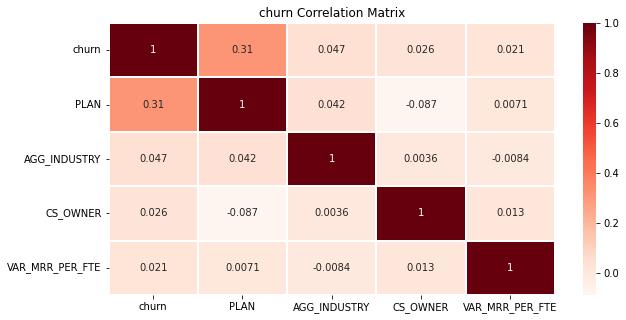

In [25]:
correlation_matrix(entityid_df, 'churn')

In [26]:
# entityid_df.to_csv('/home/gmaragkakis/Downloads/entity_df.csv', index=False)
# entityid_df = pd.read_csv('/home/gmaragkakis/Downloads/entity_df.csv')

In [27]:
important_features = backward_elim(entityid_df.drop(['ENTITY_ID', 'NAME', 'ORGANISATION_ID', 'ORGANISATION_NAME'], 1), 'churn')
important_features.insert(0, "ENTITY_ID")
extented_important_features = important_features.copy()
extented_important_features.extend(['churn'])
entity_df = entityid_df[extented_important_features].copy()
entity_df

,ENTITY_ID,COUNTRY,fload_lload,IS_FLAGSHIP,BUNDLE,AGG_INDUSTRY,HEALTHSCORE,PLAN,MAIN_ENTITY,FIX_MRR,AGE,churn
0,--p-12dr9z7wv-,8,104.0,0.0,0.0,2.0,65.0,1.0,1.0,0.0,8,0
1,-0iw08wtqdeoih,2,333.0,0.0,1.0,1.0,65.0,2.0,1.0,50.0,13,0
2,-1p9n4fyn7xken,14,286.0,0.0,3.0,1.0,65.0,4.0,1.0,50.0,9,0
3,-1sv6xt88a1ivw,14,0.0,0.0,3.0,1.0,65.0,4.0,1.0,0.0,2,1
4,-29j_ewxfo5ss3,14,213.0,0.0,2.0,1.0,25.0,2.0,1.0,159.0,10,0
...,...,...,...,...,...,...,...,...,...,...,...,...
5872,zyvy8jmjd48806,15,-1.0,0.0,1.0,1.0,25.0,4.0,1.0,0.0,0,0
5873,zyyt79ue2y0q_x,14,0.0,0.0,3.0,3.0,65.0,2.0,1.0,179.0,11,0
5874,zyz9ciui8xhmy1,14,550.0,0.0,3.0,1.0,65.0,4.0,1.0,399.0,18,0
5875,zz0ual9i-ikefn,8,202.0,0.0,3.0,1.0,65.0,2.0,1.0,179.0,7,0


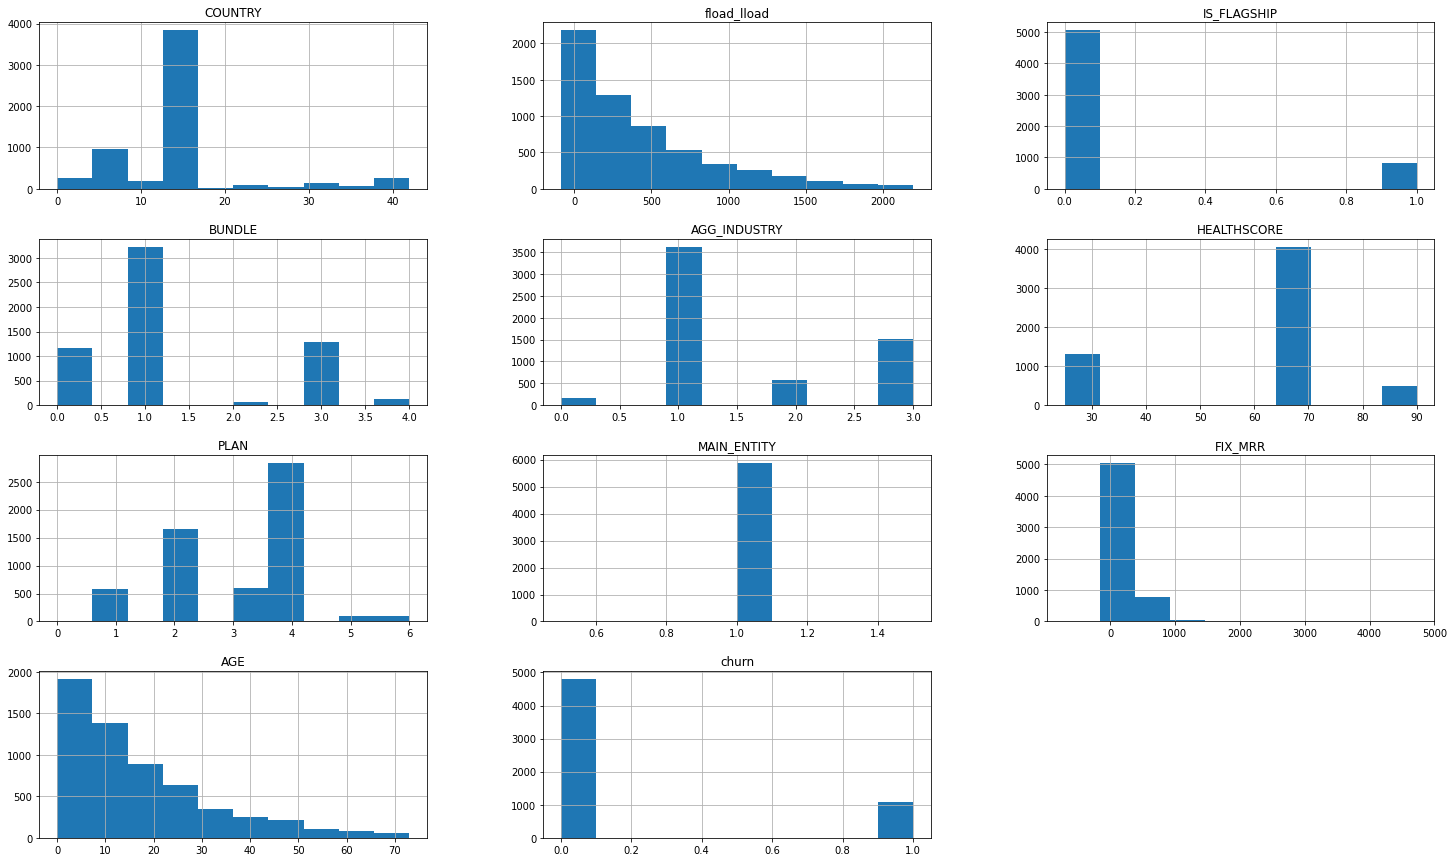

In [28]:
fig = plt.figure(figsize = (25,15))
ax = fig.gca()
entity_df.hist(ax = ax)
plt.show()

# Create input and output vectors

In [29]:
input_df = entity_df[important_features].copy()
output_df = entity_df[['ENTITY_ID','churn']].copy()
X = input_df.values
y = output_df.values

# Visualize the target variable

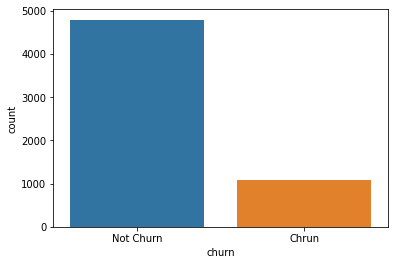

In [30]:
# visualize the target variable
g = sns.countplot(entity_df['churn'])
g.set_xticklabels(['Not Churn','Churn'])
plt.show()

# Split the dataset to train/test and train the model

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

entity_ids = np.concatenate([sublist[:1] for sublist in y_test], axis=0 )

X_train = del_entity_id(X_train)
X_test = del_entity_id(X_test)
y_train = del_entity_id(y_train)
y_test = del_entity_id(y_test)

# uncomment to apply SMOTE analysis to balance the dataset
smote = SMOTE()
y_train = y_train.flatten()
y_train = y_train.astype('int')
X_train, y_train = smote.fit_resample(X_train, y_train)
# in_scaler, out_scaler, X_train_scaled, y_train_scaled = scale_data(X_train, y_train.reshape(-1, 1))
# label_encoder = LabelEncoder()
# y_train_scaled = label_encoder.fit_transform(y_train_scaled)

# in_scaler, out_scaler, X_train_scaled, y_train_scaled = scale_data(X_train, y_train)
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
label_encoder = LabelEncoder()
y_test = label_encoder.fit_transform(y_test)

# Target after the SMOTE analysis

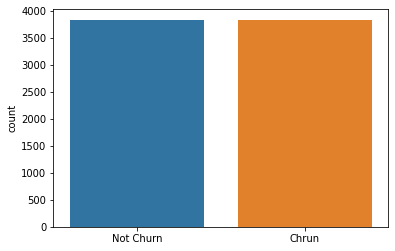

In [32]:
# visualize the target variable
g = sns.countplot(y_train)
g.set_xticklabels(['Not Churn','Churn'])
plt.show()

In [33]:
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(gamma='auto')))
# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
#     cv_results = cross_val_score(model, X_train_scaled, y_train_scaled, cv=kfold, scoring='accuracy')
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

LR: 0.846972 (0.016812)
LDA: 0.849054 (0.016142)
KNN: 0.892421 (0.010807)
NB: 0.842281 (0.015053)
SVM: 0.834333 (0.013455)


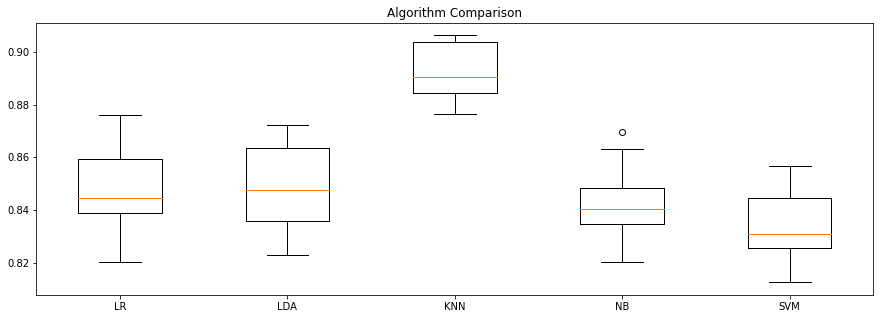

In [34]:
fig = plt.figure(figsize = (15,5))
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()

In [35]:
clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
probs = clf.predict_proba(X_test)
churning_customers = probs[:,1]

# uncomment for scaling
# clf = LogisticRegression()
# clf.fit(X_train_scaled, y_train_scaled)
# X_test_scaled = in_scaler.transform(X_test)
# y_pred = clf.predict(X_test_scaled)
# y_pred = out_scaler.inverse_transform(y_pred.reshape(-1, 1))
# probs = clf.predict_proba(X_test_scaled)[:,1]
# churning_customers = out_scaler.inverse_transform(probs.reshape(-1, 1)).flatten()

In [36]:
# Evaluate predictions
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.8545918367346939
[[834 120]
 [ 51 171]]
              precision    recall  f1-score   support

           0       0.94      0.87      0.91       954
           1       0.59      0.77      0.67       222

    accuracy                           0.85      1176
   macro avg       0.77      0.82      0.79      1176
weighted avg       0.88      0.85      0.86      1176



# This boundary seems to fit almost perfectly the different classes, churning and non churning customers

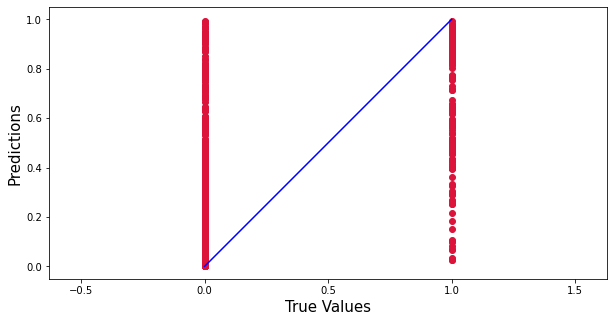

In [37]:
plt.figure(figsize=(10,5))
plt.scatter(y_test, churning_customers, c='crimson')
p1 = max(max(churning_customers), max(y_test))
p2 = min(min(churning_customers), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

# ROC_AUC
- The Area Under the Curve (AUC) is the measure of the ability of a classifier to distinguish between high risk and non high risk customers and is used as a summary of the ROC curve. The higher the AUC, the better the performance of the model at distinguishing between the positive and negative classes.
- Here is 0.90, which is pretty good

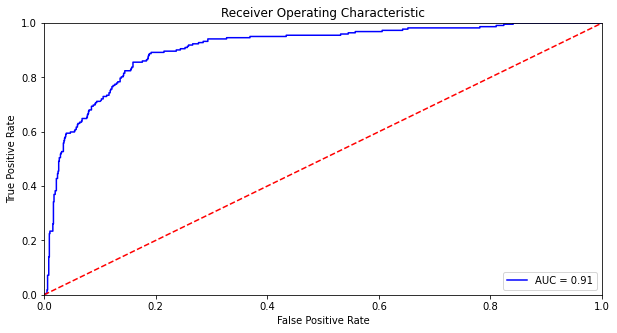

In [38]:
preds = churning_customers
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

fig = plt.figure(figsize = (10,5))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [39]:
pred_df = (pd.DataFrame({'HIGH_RISK_CUSTOMERS':churning_customers * 100})).round(2)
pred_df['ENTITY_ID'] = entity_ids
pred_df.sort_values(by=['HIGH_RISK_CUSTOMERS'], ignore_index=True, ascending=False, inplace=True)
pred_df['HIGH_RISK_CUSTOMERS'] = pred_df['HIGH_RISK_CUSTOMERS'].astype(str) + ' %'
pred_df

,HIGH_RISK_CUSTOMERS,ENTITY_ID
0,99.44 %,HJq3Z97z3G
1,99.23 %,1p7Njm-Lbc
2,98.88 %,rJje7ngBBf
3,98.79 %,BJ9F95PKFx
4,98.68 %,2znzp_nmz47g8d
...,...,...
1171,0.24 %,6itassfhwuu9bn
1172,0.23 %,faz--k15der0hn
1173,0.16 %,c2te66zqpwqskz
1174,0.13 %,ve86q4_nclo_q1
